In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
groups = ["total", "exists", "nascent"]
array = []
columns = None
for group in groups:
    path = "results/pySCENIC_output_%s/auc.csv" % group
    # path = "results/pySCENIC_output_%s/binary.csv" % group
    m = pd.read_csv(path, sep="\t", index_col=0)
    array.append(m)
    if columns is None:
        columns = set(m.columns)
    else:
        columns = columns & set(m.columns)
columns = list(sorted(set(columns)))
for i, m in enumerate(array):
    for c in columns:
        if c not in m.columns:
            m[c] = 0.0
    array[i] = m[columns]
adata = ad.AnnData(array[0])
adata.layers["total"] = array[0]
adata.layers["exists"] = array[1]
adata.layers["nascent"] = array[2]
adata1 = ad.read_h5ad("../10_blastocyst/results/scanpy_processed_gene_based.h5ad")
adata = adata[adata.obs.index.isin(adata1.obs.index), :]
adata.obs = adata1.obs.loc[adata.obs.index].copy()
adata = adata[(adata.obs["Time"] == 3) & (adata.obs["s4U"] == 400) & (adata.obs["ActD"].isna()), :]

In [3]:
# cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
cts = ["EPI", "PE", "muralTE", "polarTE"]
ss = []
for group in groups:
    for ct in cts:
        s = pd.Series(adata[adata.obs["CellType"] == ct, :].layers[group].mean(axis=0))
        s.name = "%s.%s" % (ct, group)
        s.index = adata.var.index.values
        ss.append(s)

In [6]:
d = pd.concat(ss, axis=1)
d = d[d.max(axis=1) > 0.1]
d.index.name = "Regulon"
d.to_csv("results/regulon_activity.csv")

In [7]:
d = d[~d.index.isin(["Ybx1(+)", "Jund(+)", "Klf5(+)", "Mtf2(+)"])]

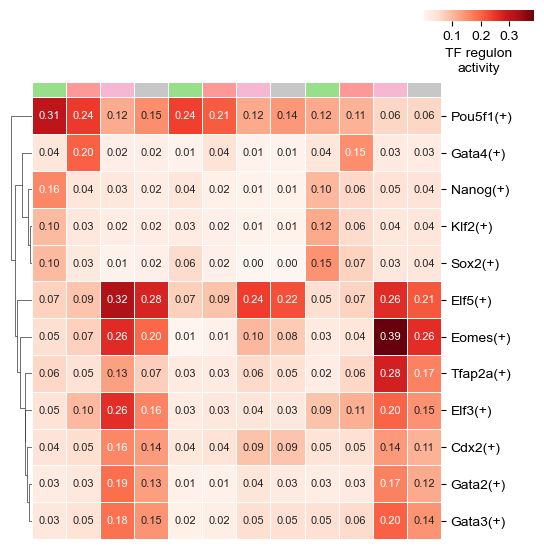

In [8]:
cmap = plt.colormaps["tab20"]
col_colors = [cmap(5), cmap(7), cmap(13), cmap(15)] * 3
tmp = d.copy()
tmp.columns = [None] * tmp.shape[1]
ret = sns.clustermap(tmp, cmap="Reds", col_cluster=False, cbar_pos=(0.78, 0.97, 0.2, 0.02), 
               dendrogram_ratio=[0.05, 0.12], 
               col_colors=col_colors,
               lw=0.5, 
                cbar_kws=dict(orientation="horizontal", label="TF regulon\nactivity"),
               annot=True, fmt=".2f", annot_kws=dict(size=8), figsize=(5.5, 5.5))
ax = ret.ax_heatmap
ax.set_xticks([])
ax.set_ylabel(None)
ret.fig.savefig("figures/clustermap_tf_regulon_activity.pdf")

In [54]:
adata2 = adata1[adata1.obs.index.isin(adata.obs.index),:].copy()
for group in ["total", "exists", "nascent"]:
    m = pd.DataFrame(adata.layers[group].toarray(), index=adata.obs.index.copy(), columns=adata.var.index.copy())  
    for c in m.columns:
        adata2.obs["%s.%s" % (group, c)] = m[c]

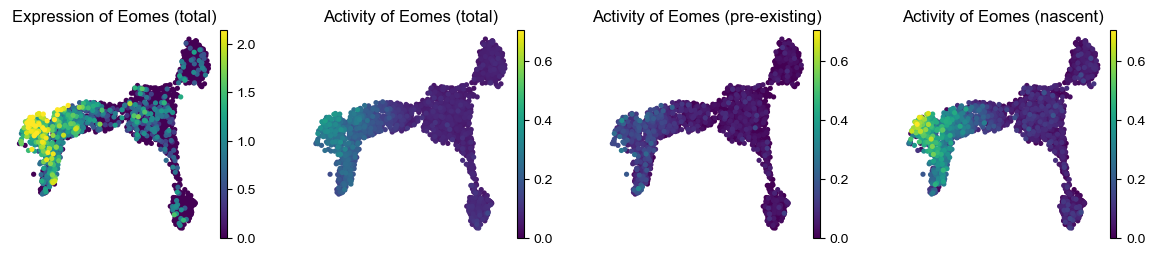

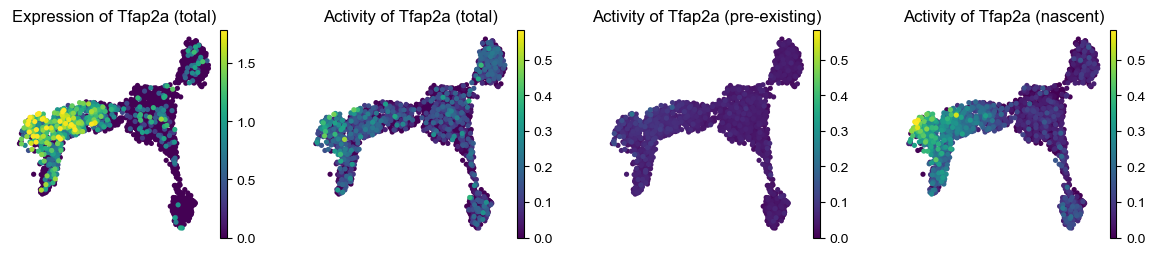

In [77]:
for gene in ["Eomes", "Tfap2a"]:
    with plt.rc_context({"figure.figsize": (2.7, 2.7)}):
        vmax = adata2.obs[["total.%s(+)" % gene, "exists.%s(+)" % gene, "nascent.%s(+)" % gene]].max().max()
        sc.pl.umap(adata2, 
                   color=[gene, "total.%s(+)" % gene, "exists.%s(+)" % gene, "nascent.%s(+)" % gene], 
                   vmin=0, vmax=["p99", vmax, vmax, vmax], 
                   frameon=False, ncols=4,
                   title=["Expression of %s (total)" % gene, "Activity of %s (total)" % gene, "Activity of %s (pre-existing)" % gene, "Activity of %s (nascent)" % gene], 
                   save="_regulon_activity_of_%s.pdf" % gene)